# Modeling and Analysis
*Deval Mehta*

With EDA complete, we move on to our main task: creating data-driven models to make better decisions about bus routes. In addition to the conventional machine learning models we have discussed throughout the course of DSB, we explore **graph-based analysis** here, treating the network of bus stops across eastern Queens as a graph, where the nodes are stops and the edges are connections between stops, based either on established routes or using a distance heuristic. Our goals for modeling are as follows:
- Instantiate and run DBSCAN to check for areas of high and low density, which will be transit hubs and underserved areas
- Model the stop network as a graph, then use PageRank to define transit hubs and underserved areas

DBSCAN and PageRank both proved unfruitful for different reasons. In the case of DBSCAN, finding an adequate value for epsilon proved difficult. PageRank is designed for directed graphs and New York's public transit network is better described as an undirected graph. For these reasons, we opt instead for HDBSCAN, which no longer requires specifying the parameter `eps` and the Louvain method, a greedy algorithm for determining the community structure of a graph.

## Imports and Reading in Data

In [24]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import networkx as nx
import community as clouvain
import glob
import hdbscan

from collections import Counter
from geopy.distance import geodesic
from itertools import combinations
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree
from tqdm import tqdm

In [2]:
# File Paths
data_directory = "../data/"
static_data_file = f"{data_directory}stops.csv"
geojson_file = f"{data_directory}nyc_by_neighborhood_2020.geojson"
real_time_files_pattern = f"{data_directory}realtime_data_MTA NYCT_*.csv"

In [3]:
# Load Static Data
stops_data = pd.read_csv(static_data_file)
stops_data.rename(
    columns={
        "Route ID": "route_id",
        "Stop ID": "stop_id",
        "Stop Name": "stop_name",
        "Latitude": "stop_lat",
        "Longitude": "stop_lon",
    },
    inplace=True,
)
stops_data["coords"] = stops_data[["stop_lat", "stop_lon"]].apply(tuple, axis=1)

# Convert to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

In [4]:
# Load Queens Map
nyc_map = gpd.read_file(geojson_file)
queens_map = nyc_map[nyc_map["boroname"].str.contains("Queens", case=False)]

In [36]:
# Function to visualize results
def visualize_clusters(df, cluster_col, title, map_data=None, map_color="lightgray", map_edgecolor="black"):
    """
    Visualize clusters with transparency and overlay a layer showing all stops.

    Parameters:
    - df: GeoDataFrame containing the clustering results.
    - cluster_col: Column name for cluster/community IDs.
    - title: Title for the plot.
    - map_data: GeoDataFrame for the base map (optional).
    - map_color: Color for the base map (default: light gray).
    - map_edgecolor: Edge color for the base map (default: black).
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the base map (e.g., Queens neighborhoods)
    if map_data is not None:
        map_data.plot(ax=ax, color=map_color, edgecolor=map_edgecolor, alpha=0.5)
    
    # Plot all stops with a neutral color as a separate layer
    df.plot(ax=ax, color="black", markersize=10, alpha=0.5, label="All Stops")
    
    # Overlay clusters with transparency
    df.plot(
        ax=ax,
        column=cluster_col,
        cmap="tab20b",
        markersize=20,
        alpha=0.7,  # Add transparency to clusters
        legend=True
    )
    
    # Add title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

In [6]:
# Load Real-Time Data
real_time_files = glob.glob(real_time_files_pattern)
real_time_data = pd.concat([pd.read_csv(file) for file in real_time_files], ignore_index=True)

# Rename columns for consistency
real_time_data.rename(
    columns={
        "Route ID": "route_id",
        "Vehicle ID": "vehicle_id",
        "Latitude": "vehicle_lat",
        "Longitude": "vehicle_lon",
        "Timestamp": "timestamp",
    },
    inplace=True,
)

# Ensure timestamp is parsed
real_time_data["timestamp"] = pd.to_datetime(real_time_data["timestamp"])

# Sort by route, vehicle, and timestamp
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

In [7]:
# Extract coordinates from stops_data
stop_coords = np.radians(stops_data[["stop_lat", "stop_lon"]].values)

# Extract vehicle coordinates from real-time data
real_time_coords = np.radians(real_time_data[["vehicle_lat", "vehicle_lon"]].values)

# Build a KDTree for efficient nearest neighbor search
stop_tree = cKDTree(stop_coords)

# Query the nearest stop for each real-time data point
distances, indices = stop_tree.query(real_time_coords)

# Assign the nearest stop_id to each real-time record
real_time_data["nearest_stop_id"] = stops_data.iloc[indices]["stop_id"].values
real_time_data["distance_to_stop"] = distances * 6371  # Convert radians to kilometers

## DBSCAN

In [43]:
# Step 1: Run DBSCAN
eps = 0.00005  # Adjust based on your data
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine")
stops_data["cluster"] = dbscan.fit_predict(np.radians(stops_data[["stop_lat", "stop_lon"]]))

In [44]:
# Step 2: Save and Visualize Clusters
stops_data.to_csv(f"{data_directory}dbscan_clusters.csv", index=False)
print("DBSCAN Cluster Counts:")
print(stops_data["cluster"].value_counts())

DBSCAN Cluster Counts:
cluster
 0    1996
 2     141
-1      74
 4      42
 6      18
 5      17
 1       8
 3       4
Name: count, dtype: int64


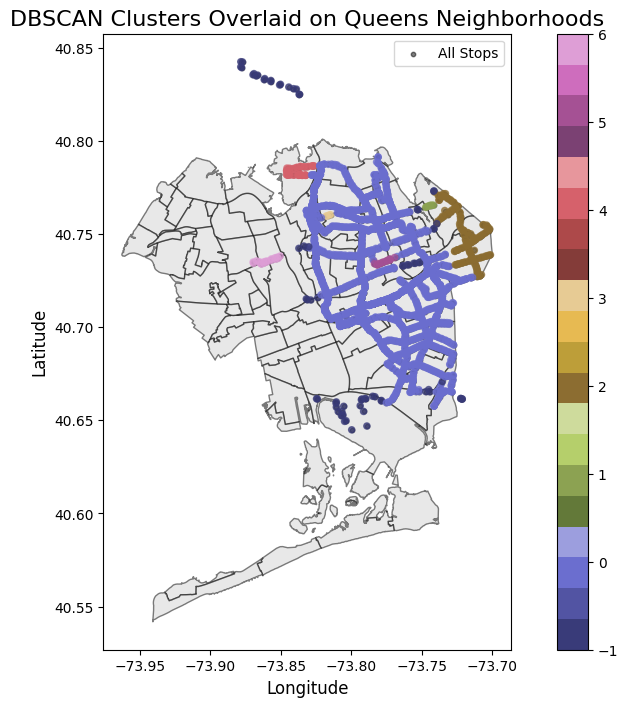

In [45]:
# Convert stops_data to GeoDataFrame if not already done
stops_gdf = gpd.GeoDataFrame(
    stops_data,
    geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326"
)

# Visualize DBSCAN Clusters with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="cluster", 
    title="DBSCAN Clusters Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

## PageRank
PageRank was developed by Google to rank webpages by importance, using the number of links leading to them as a proxy. It has since been generalized to apply to any directed graph. Modeling bus stops in this way should allow us to identify areas of high and low density, just as clustering would, but without machine learning.

In [46]:
# Step 1: Construct Edges Based on Proximity
distance_threshold = 0.1  # in kilometers (500 meters)
edges = []

print("Constructing edges for PageRank...")
for stop1, stop2 in tqdm(combinations(stops_data["stop_id"], 2), desc="Computing edges"):
    coord1 = stops_data.loc[stops_data["stop_id"] == stop1, "coords"].values[0]
    coord2 = stops_data.loc[stops_data["stop_id"] == stop2, "coords"].values[0]
    if geodesic(coord1, coord2).kilometers <= distance_threshold:
        edges.append((stop1, stop2))

Constructing edges for PageRank...


Computing edges: 2643850it [27:33, 1598.56it/s]


In [47]:
# Step 2: Create a Directed Graph
G = nx.DiGraph()

# Add nodes
for _, row in stops_data.iterrows():
    G.add_node(row["stop_id"], latitude=row["stop_lat"], longitude=row["stop_lon"])

# Add edges
G.add_edges_from(edges)

In [48]:
# Step 3: Compute PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)
stops_data["pagerank"] = stops_data["stop_id"].map(pagerank_scores)

# Step 4: Save and Visualize PageRank Results
stops_data.to_csv(f"{data_directory}pagerank_results.csv", index=False)
print("Top 10 Bus Stops by PageRank:")
print(stops_data.sort_values("pagerank", ascending=False).head(10))

Top 10 Bus Stops by PageRank:
             route_id     stop_id                 stop_name   stop_lat  \
574    MTA%20NYCT_Q13  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
1046   MTA%20NYCT_Q28  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
802   MTA%20NYCT_Q20B  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
678   MTA%20NYCT_Q20A  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
67      MTA%20NYCT_Q1  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
135     MTA%20NYCT_Q2  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1351   MTA%20NYCT_Q36  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1717   MTA%20NYCT_Q76  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1833   MTA%20NYCT_Q77  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1447   MTA%20NYCT_Q43  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   

       stop_lon                   coords  hdbscan_cluster  louvain_community  \
574  -73.828177  (40.760694, -73.828177)                0                1.

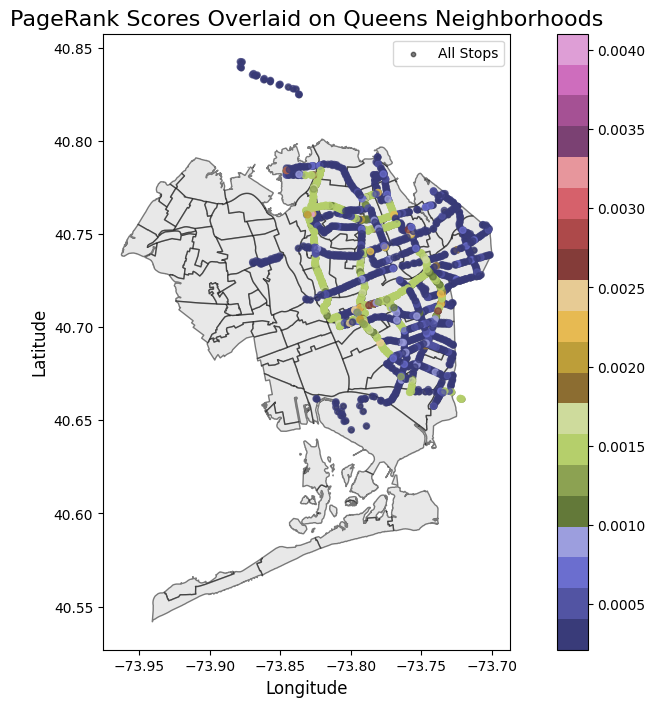

In [50]:
# Convert stops_data to GeoDataFrame if not already done
stops_gdf = gpd.GeoDataFrame(
    stops_data,
    geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326"
)

# Visualize PageRank Scores with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="pagerank", 
    title="PageRank Scores Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

## HDBSCAN

In [ ]:
# Compute k-nearest neighbors
coords_radians = np.radians(stops_data[["stop_lat", "stop_lon"]].values)
k = 5  # Choose a small k for local density estimation
nbrs = NearestNeighbors(n_neighbors=k, metric="haversine").fit(coords_radians)
distances, indices = nbrs.kneighbors(coords_radians)

# Plot k-distance graph
distances = np.sort(distances[:, -1])  # k-th nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.plot(distances, label=f"{k}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel("Distance (radians)")
plt.axhline(y=0.00005, color="r", linestyle="--", label="Example Threshold (0.00005)")
plt.legend()
plt.show()

In [41]:
# Define grid search ranges
min_cluster_size_range = [50, 100, 150]  # Larger clusters
min_samples_range = [20, 30, 40]         # Tighten density requirements

# Grid search for HDBSCAN parameters
best_model = None
best_score = float("-inf")

print("Performing grid search over HDBSCAN parameters...")
for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="haversine"
        )
        labels = clusterer.fit_predict(coords_radians)
        
        # Compute Silhouette Score for validation
        if len(set(labels)) > 1:
            score = silhouette_score(coords_radians, labels, metric="haversine")
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}, Silhouette Score={score:.3f}")
            if score > best_score:
                best_score = score
                best_model = clusterer

# Assign best HDBSCAN results
stops_data["hdbscan_cluster"] = best_model.labels_

# Update stops_gdf to include the HDBSCAN cluster labels
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

Performing grid search over HDBSCAN parameters...
min_cluster_size=50, min_samples=20, Silhouette Score=0.117
min_cluster_size=50, min_samples=30, Silhouette Score=0.106
min_cluster_size=50, min_samples=40, Silhouette Score=-0.061
min_cluster_size=100, min_samples=20, Silhouette Score=0.004
min_cluster_size=100, min_samples=30, Silhouette Score=-0.070
min_cluster_size=100, min_samples=40, Silhouette Score=-0.079
min_cluster_size=150, min_samples=20, Silhouette Score=0.004
min_cluster_size=150, min_samples=30, Silhouette Score=0.181
min_cluster_size=150, min_samples=40, Silhouette Score=-0.037


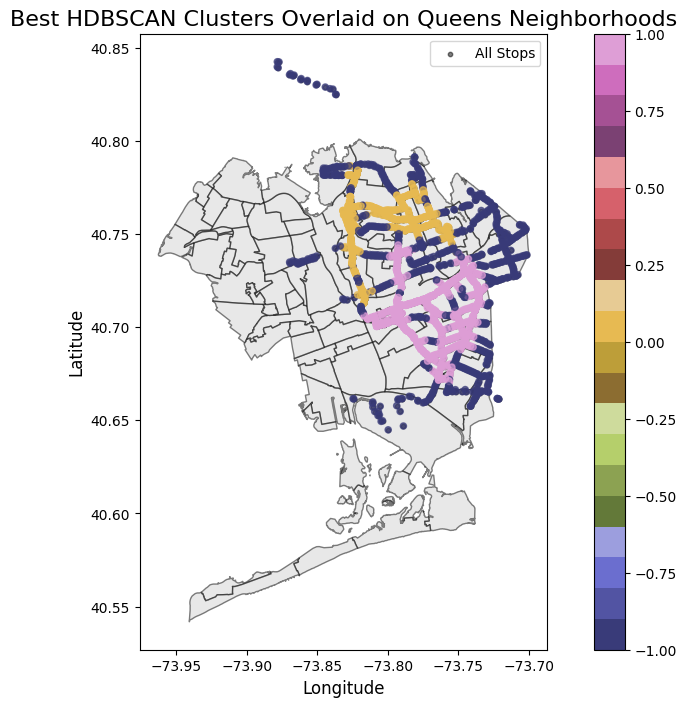

Best HDBSCAN clustering complete. Results saved.


In [42]:
# Visualize HDBSCAN clusters
visualize_clusters(
    stops_gdf,
    cluster_col="hdbscan_cluster",
    title="Best HDBSCAN Clusters Overlaid on Queens Neighborhoods",
    map_data=queens_map
)

# Save HDBSCAN results
stops_data.to_csv(f"{data_directory}hdbscan_best_clusters.csv", index=False)
print("Best HDBSCAN clustering complete. Results saved.")

## Louvain Method

In [29]:
# Add edges with weights from real-time data
edges = []
for route_id in real_time_data["route_id"].unique():
    route_data = real_time_data[real_time_data["route_id"] == route_id]
    for vehicle_id in route_data["vehicle_id"].unique():
        vehicle_data = route_data[route_data["vehicle_id"] == vehicle_id]
        stops = vehicle_data["nearest_stop_id"].tolist()
        for i in range(len(stops) - 1):
            stop1, stop2 = stops[i], stops[i + 1]
            if stop1 != stop2:  # Avoid self-loops
                coord1 = stops_data.loc[stops_data["stop_id"] == stop1, "coords"].values[0]
                coord2 = stops_data.loc[stops_data["stop_id"] == stop2, "coords"].values[0]
                distance = geodesic(coord1, coord2).kilometers
                edges.append((stop1, stop2, {"weight": 1 / distance}))  # Weight by inverse distance

# Filter edges by weight (e.g., distance or frequency)
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] > threshold]
# Sort real-time data for each vehicle and route
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

In [30]:
# Create Graph with Real-Time Data Edges
G = nx.Graph()

# Add nodes
G.add_nodes_from(stops_data["stop_id"])

# Add edges from real-time data
G.add_edges_from(edges)

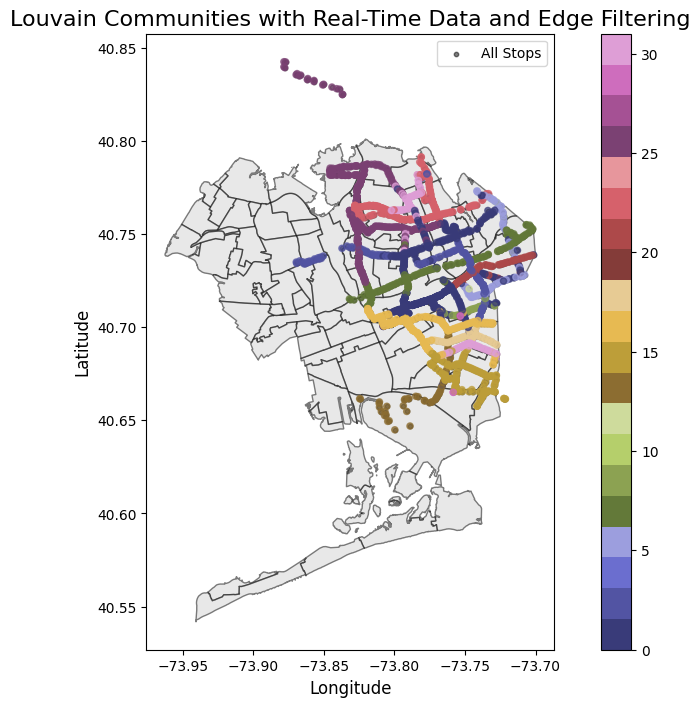

Louvain clustering with real-time data complete. Results saved.


In [38]:
# Filter edges by weight
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in edges if d["weight"] > threshold]

# Create graph with filtered edges
G = nx.Graph()
G.add_edges_from(filtered_edges)

# Run Louvain Method with higher resolution
partition = clouvain.best_partition(G, weight="weight", resolution=2.0)  # Higher resolution for finer clusters
stops_data["louvain_community"] = stops_data["stop_id"].map(partition)

# Visualize Louvain communities
visualize_clusters(
    stops_gdf,
    cluster_col="louvain_community",
    title="Louvain Communities with Real-Time Data and Edge Filtering",
    map_data=queens_map
)

# Save Louvain results
stops_data.to_csv(f"{data_directory}louvain_with_realtime.csv", index=False)
print("Louvain clustering with real-time data complete. Results saved.")

In [32]:
# Save Louvain results
stops_data.to_csv(f"{data_directory}louvain_communities_realtime.csv", index=False)
print("Louvain community detection with real-time edges complete. Results saved.")

Louvain community detection with real-time edges complete. Results saved.


In [33]:
# Modularity
modularity_score = clouvain.modularity(partition, G, weight="weight")
print(f"Modularity Score: {modularity_score:.4f}")

# Community Size Distribution
community_sizes = Counter(partition.values())
print("Community Size Distribution:", community_sizes)

Modularity Score: 0.7602
Community Size Distribution: Counter({3: 132, 12: 114, 15: 106, 26: 100, 21: 100, 11: 88, 7: 83, 0: 81, 4: 79, 6: 70, 23: 68, 10: 62, 9: 60, 20: 59, 2: 56, 1: 50, 25: 48, 17: 47, 14: 45, 18: 44, 22: 43, 16: 38, 13: 34, 24: 16, 8: 12, 5: 3, 19: 2})


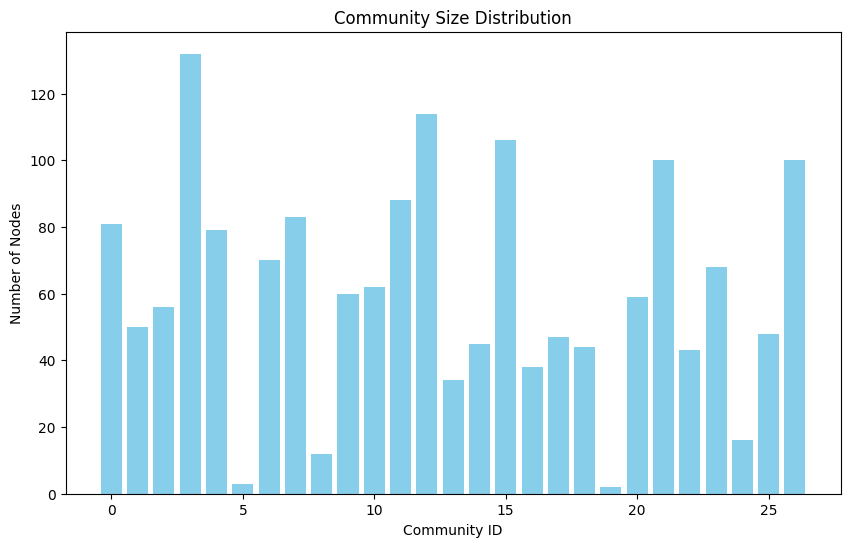

In [34]:
# Plot Community Size Distribution
plt.figure(figsize=(10, 6))
plt.bar(community_sizes.keys(), community_sizes.values(), color="skyblue")
plt.title("Community Size Distribution")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

In [35]:
# Coverage
def compute_coverage(G, partition):
    intra_edges = sum(1 for edge in G.edges if partition[edge[0]] == partition[edge[1]])
    total_edges = G.number_of_edges()
    return intra_edges / total_edges

coverage = compute_coverage(G, partition)
print(f"Coverage: {coverage:.4f}")

Coverage: 0.4076


In [39]:
import folium

# Create a map
map_center = [stops_gdf["stop_lat"].mean(), stops_gdf["stop_lon"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add stops
for _, row in stops_gdf.iterrows():
    folium.CircleMarker(
        location=(row["stop_lat"], row["stop_lon"]),
        radius=3,
        color="black",
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

# Save or display the map
m.save("louvain_clusters_map.html")